In [212]:
model_name = 'RGNN' ## change name here

In [213]:
from minisom import MiniSom
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import rdkit
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, AllChem
import matplotlib.gridspec as gridspec
from rdkit.Chem.Scaffolds import MurckoScaffold
%matplotlib inline

# prepare functions

In [214]:
def plot_som_scatter(fps,label_names):
    w_x, w_y = zip(*[som.winner(d) for d in fps])
    w_x = np.array(w_x)
    w_y = np.array(w_y)
    colors = ['C0', 'C1', 'C2', 'C3']

    plt.figure(figsize=(10, 9))
    plt.pcolor(som.distance_map().T, cmap='bone_r', alpha=.2)
    plt.colorbar()

    for c in np.unique(confusions):
        idx_target = confusions==c
        plt.scatter(w_x[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8,
                    w_y[idx_target]+.5+(np.random.rand(np.sum(idx_target))-.5)*.8, 
                    s=20, c=colors[c], label=label_names[c])
    plt.legend(loc='upper right')
    plt.grid()
    out_path = '/home/kongyue/private-kongyue/paper-RGNN/SOM/maps/' + model_name + '_scatter.png'
    plt.savefig(out_path)
    plt.show()
    
def plot_som_pie(fps, label_names):
    labels_map = som.labels_map(fps, [label_names[t] for t in confusions])

    fig = plt.figure(figsize=(15, 15))
    the_grid = gridspec.GridSpec(20, 20, fig)
    for position in labels_map.keys():
        label_fracs = [labels_map[position][l] for l in label_names.values()]
        plt.subplot(the_grid[20-1-position[1],
                            position[0]], aspect=1)
        patches, texts = plt.pie(label_fracs)
        
    plt.legend(patches, label_names.values(),bbox_to_anchor=(12.5, 3.5)) # , , ncol=3
    out_path = '/home/kongyue/private-kongyue/paper-RGNN/SOM/maps/' + model_name + '_pie.png'
    plt.savefig(out_path)
    plt.show()

def draw_multiple_mol(smiles_list, mols_per_row=4, file_path=None, useSVG=True):
    mols = []
    for i in smiles_list:
        mols.append(Chem.MolFromSmiles(i))
    mols_per_row = min(len(smiles_list), mols_per_row)
    img=Draw.MolsToGridImage(mols, molsPerRow=mols_per_row, subImgSize=(300, 300), useSVG=useSVG)
    if file_path and useSVG:
        with open(file_path, 'w') as f_handle:
            f_handle.write(img.data)
    return img

def average_similarity(morgan_fps):
    sims = []
    import itertools
    for (i,j) in itertools.combinations(morgan_fps,2):
        sims.append(DataStructs.FingerprintSimilarity(i,j))
    avg_sim = np.mean(sims)
    return avg_sim

def neuron_similarity(loc):
    idx = locs_dict[loc]
    smis = df.smi[idx].to_list()
    rgs = df.rg[idx].to_list()
    mols = [Chem.MolFromSmiles(smi) for smi in smis]
    rg_mols = [Chem.MolFromSmiles(rg) for rg in rgs]
    morgan_fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024) for mol in mols]
    morgan_rg_fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024) for mol in rg_mols]
    avg_mol_sim = average_similarity(morgan_fps)
    avg_rg_sim = average_similarity(morgan_rg_fps)
    return avg_mol_sim, avg_rg_sim

# data process

In [215]:
path = '/home/kongyue/private-kongyue/paper-RGNN/SOM/fingerprints/' + model_name  + '_test.csv'
df = pd.read_csv(path)
df['confusion'] = np.NAN
sample_num = df.shape[0]
tp_sel = (df['Serine_threonine-protein_kinase_Aurora-A'] == 1) & (df['pred'] == 1)
tn_sel = (df['Serine_threonine-protein_kinase_Aurora-A'] == 0) & (df['pred'] == 0)
fp_sel = (df['Serine_threonine-protein_kinase_Aurora-A'] == 0) & (df['pred'] == 1)
fn_sel = (df['Serine_threonine-protein_kinase_Aurora-A'] == 1) & (df['pred'] == 0)
df.loc[tp_sel,'confusion'] = 0
df.loc[tn_sel,'confusion'] = 1
df.loc[fp_sel,'confusion'] = 2
df.loc[fn_sel,'confusion'] = 3
df.confusion = df.confusion.astype(int)

fps = df.iloc[:, 5:-1].values
ys = df['Serine_threonine-protein_kinase_Aurora-A'].values
y_preds = df['pred'].values
confusions = df['confusion'].values
label_names = {0:'TP',1:'TN',2:'FP',3:'FN'}
colors = ['C0', 'C1', 'C2', 'C3']

n_neurons = 10
m_neurons = 10

# load model

In [216]:
model_path = '/home/kongyue/private-kongyue/paper-RGNN/SOM/models/' + model_name +'_som.p'
with open(model_path, 'rb') as infile:
    som = pickle.load(infile)


# plot SOM maps

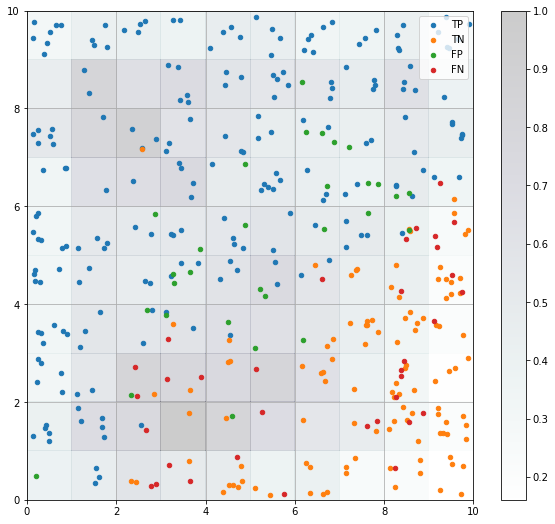

In [217]:
plot_som_scatter(fps,label_names)

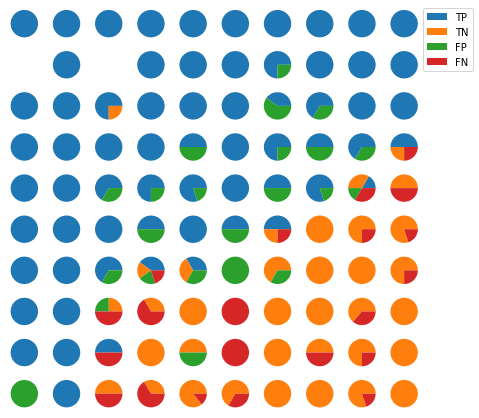

In [218]:
plot_som_pie(fps,label_names)

# draw mols in each neuron

In [220]:
locs = [(i,j) for i in range(n_neurons) for j in range(m_neurons)]
locs_dict = {loc:[] for loc in locs}

for i in range(sample_num):
    locs_dict[som.winner(fps[i])].append(i)


In [173]:
locs_dict

{(0, 0): [242],
 (0, 1): [168, 232, 250, 320, 368],
 (0, 2): [65, 92, 226, 231, 264],
 (0, 3): [20, 48, 87, 148, 193, 298],
 (0, 4): [18, 106, 121, 246, 369],
 (0, 5): [196, 218, 269, 322, 344, 355, 382],
 (0, 6): [77, 131, 191],
 (0, 7): [45, 67, 98, 110, 345, 348],
 (0, 8): [],
 (0, 9): [1, 47, 124, 129, 327, 364, 373],
 (1, 0): [128, 329, 370],
 (1, 1): [63, 202, 325, 343, 378],
 (1, 2): [179, 211],
 (1, 3): [61, 132, 159],
 (1, 4): [94, 328],
 (1, 5): [79, 142, 209, 301],
 (1, 6): [194],
 (1, 7): [374],
 (1, 8): [139, 273],
 (1, 9): [59, 147, 247, 261],
 (2, 0): [174, 257, 321, 333],
 (2, 1): [22, 358],
 (2, 2): [84, 265, 295, 305],
 (2, 3): [15, 195, 223],
 (2, 4): [7, 135],
 (2, 5): [44, 157, 210],
 (2, 6): [319],
 (2, 7): [75, 113, 243, 291],
 (2, 8): [],
 (2, 9): [6, 39, 237, 259],
 (3, 0): [19, 91, 201],
 (3, 1): [93],
 (3, 2): [126, 198, 288],
 (3, 3): [82, 95, 307, 337, 372],
 (3, 4): [25, 41, 62, 73, 101, 272],
 (3, 5): [74, 138, 239, 383],
 (3, 6): [40, 78, 178, 275],
 (3,

In [63]:
for loc in locs:
    try:
        idx = locs_dict[loc]
        smis = df.smi[idx].to_list()
        mols = [Chem.MolFromSmiles(smi) for smi in smis]
        rgs = df.rg[idx].to_list()
        rg_mols = [Chem.MolFromSmiles(rg) for rg in rgs]
        mol_murckos = [MurckoScaffold.GetScaffoldForMol(m) for m in mols]
        out_mol_path = '/home/kongyue/private-kongyue/paper-RGNN/SOM/figs/' + model_name + '/' +  model_name +'_' + str(loc) + '.svg'
        out_rg_path = '/home/kongyue/private-kongyue/paper-RGNN/SOM/figs/' + model_name + '/' +  model_name +'_' + str(loc) + '_rg.svg'
        out_MS_path = '/home/kongyue/private-kongyue/paper-RGNN/SOM/figs/' + model_name + '/' +  model_name +'_' + str(loc) + '_MurckoScaffold.svg'
        
        draw_multiple_mol(smis, mols_per_row=3, file_path= out_mol_path)
        draw_multiple_mol(rgs, mols_per_row=3, file_path= out_rg_path)

        img = Draw.MolsToGridImage(mol_murckos,subImgSize=(300,300), useSVG=True)
        with open(out_MS_path, 'w') as f_handle:
                f_handle.write(img.data)
    except:
        pass

# calculate similarity within neurons

/home/kongyue/anaconda3/envs/t/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/kongyue/anaconda3/envs/t/lib/python3.7/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


array([[<AxesSubplot:title={'center':'mol_sim'}>,
        <AxesSubplot:title={'center':'rg_sim'}>]], dtype=object)

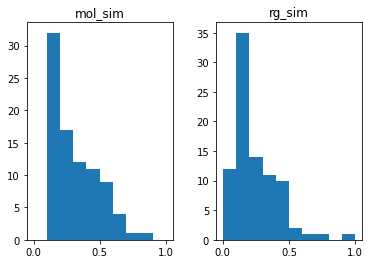

In [221]:
map_mol_sims = []
map_rg_sims = []
for loc in locs_dict:
    avg_mol_sim, avg_rg_sim = neuron_similarity(loc)
    map_mol_sims.append(avg_mol_sim)
    map_rg_sims.append(avg_rg_sim)

sim_list = list(zip(map_mol_sims,map_rg_sims))
df_sim = pd.DataFrame(sim_list,columns=['mol_sim','rg_sim'])

df_sim.hist(bins=10, range=(0,1),grid=False)

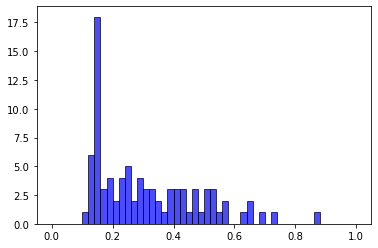

In [222]:
out_path_mol = '/home/kongyue/private-kongyue/paper-RGNN/SOM/similarity/' + model_name + '_mol_sim.png'
out_path_rg = '/home/kongyue/private-kongyue/paper-RGNN/SOM/similarity/' + model_name + '_rg_sim.png'
plt.hist(df_sim.mol_sim, bins=50, facecolor="blue", edgecolor="black", alpha=0.7, range=(0,1))
plt.savefig(out_path_mol)

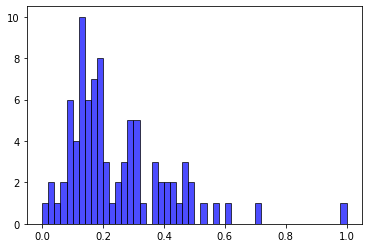

In [223]:
plt.hist(df_sim.rg_sim, bins=50, facecolor="blue", edgecolor="black", alpha=0.7, range=(0,1))
plt.savefig(out_path_rg)

# load ECFP_4

In [224]:
model_name = 'ECFP' ## 

path = '/home/kongyue/private-kongyue/paper-RGNN/SOM/fingerprints/' + model_name  + '_test.csv'
df = pd.read_csv(path)

sample_num = df.shape[0]
ys = df['Serine_threonine-protein_kinase_Aurora-A'].values
fps = df.iloc[:, 4:].values

model_path = '/home/kongyue/private-kongyue/paper-RGNN/SOM/models/' + model_name +'_som.p'
with open(model_path, 'rb') as infile:
    som = pickle.load(infile)

array([[<AxesSubplot:title={'center':'mol_sim'}>,
        <AxesSubplot:title={'center':'rg_sim'}>]], dtype=object)

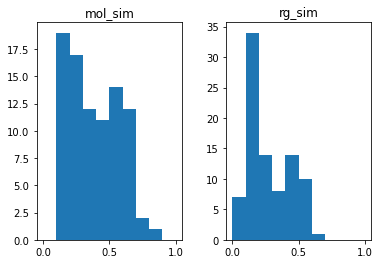

In [225]:
locs = [(i,j) for i in range(n_neurons) for j in range(m_neurons)]
locs_dict = {loc:[] for loc in locs}

for i in range(sample_num):
    locs_dict[som.winner(fps[i])].append(i)

map_mol_sims = []
map_rg_sims = []
for loc in locs_dict:
    avg_mol_sim, avg_rg_sim = neuron_similarity(loc)
    map_mol_sims.append(avg_mol_sim)
    map_rg_sims.append(avg_rg_sim)

sim_list = list(zip(map_mol_sims,map_rg_sims))
df_sim_ECFP = pd.DataFrame(sim_list,columns=['mol_sim','rg_sim'])
df_sim_ECFP.hist(bins=10, range=(0,1),grid=False)

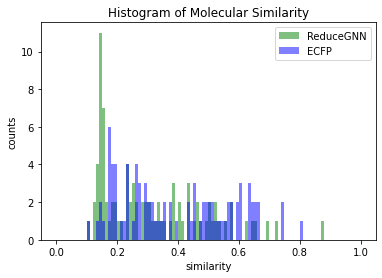

In [230]:
out_path_mol = '/home/kongyue/private-kongyue/paper-RGNN/SOM/similarity/RGNN_ECFP_mol_sim.png'

plt.hist(df_sim.mol_sim, bins=100, facecolor="green", alpha=0.5, range=(0,1),label='ReduceGNN')
plt.hist(df_sim_ECFP.mol_sim, bins=100, facecolor="blue", alpha=0.5, range=(0,1),label='ECFP')
plt.legend(loc='upper right')
plt.xlabel('similarity')
plt.ylabel('counts')
plt.title('Histogram of Molecular Similarity')
plt.savefig(out_path_mol)


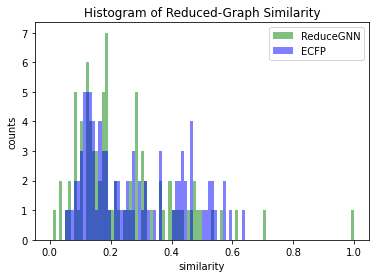

In [231]:
out_path_rg = '/home/kongyue/private-kongyue/paper-RGNN/SOM/similarity/RGNN_ECFP_rg_sim.png'
plt.hist(df_sim.rg_sim, bins=100, facecolor="green", alpha=0.5, range=(0,1),label='ReduceGNN')
plt.hist(df_sim_ECFP.rg_sim, bins=100, facecolor="blue", alpha=0.5, range=(0,1),label='ECFP')
plt.legend(loc='upper right')
plt.xlabel('similarity')
plt.ylabel('counts')
plt.title('Histogram of Reduced-Graph Similarity')
plt.savefig(out_path_rg)